<>:10: SyntaxWarning: invalid escape sequence '\O'
<>:10: SyntaxWarning: invalid escape sequence '\O'
C:\Users\15Pro\AppData\Local\Temp\ipykernel_286576\2020608840.py:10: SyntaxWarning: invalid escape sequence '\O'
  file_path = "D:\OneDrive\Project\Reverse_Distill_Training\data\exchange_rate.csv"  # 替换为你的文件路径
d:\Miniconda\envs\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Miniconda\envs\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Miniconda\envs\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Miniconda\envs\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_fin

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-47285.883, Time=1.11 sec


d:\Miniconda\envs\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-47275.624, Time=0.30 sec


d:\Miniconda\envs\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-47288.100, Time=0.31 sec


d:\Miniconda\envs\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-47288.011, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-47277.283, Time=0.12 sec


d:\Miniconda\envs\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Miniconda\envs\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-47286.168, Time=0.24 sec


d:\Miniconda\envs\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-47286.355, Time=0.52 sec


d:\Miniconda\envs\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-47284.117, Time=1.37 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-47289.724, Time=0.09 sec


d:\Miniconda\envs\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Miniconda\envs\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-47287.795, Time=0.95 sec


d:\Miniconda\envs\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-47287.991, Time=0.34 sec


d:\Miniconda\envs\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-47289.634, Time=0.24 sec


d:\Miniconda\envs\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-47271.281, Time=0.46 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 6.442 seconds
Selected ARIMA parameters: {'maxiter': 50, 'method': 'lbfgs', 'order': (1, 1, 0), 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': {}, 'seasonal_order': (0, 0, 0, 0), 'start_params': None, 'suppress_warnings': True, 'trend': None, 'with_intercept': False}
ARIMA MAE: 0.011468052083333319, ARIMA MSE: 0.0002051939218645828
Holt-Winters MAE: 0.011374415173707722, Holt-Winters MSE: 0.00020238096242311708


d:\Miniconda\envs\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Miniconda\envs\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Miniconda\envs\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Miniconda\envs\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


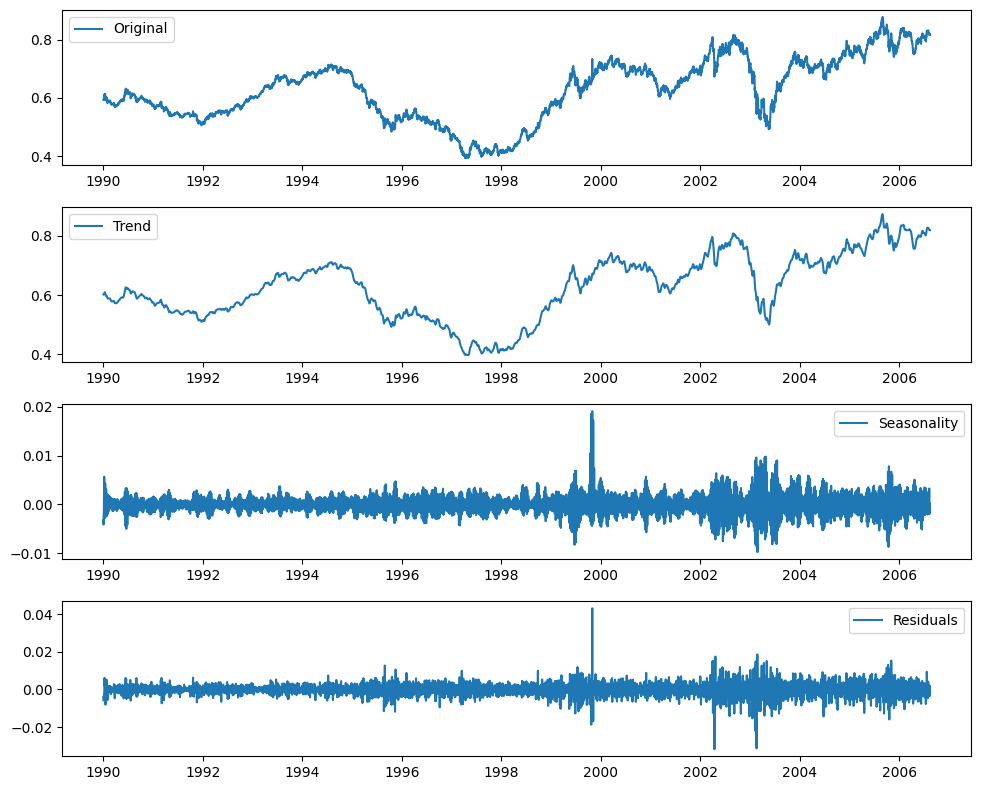

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# 读取数据集
file_path = "D:\OneDrive\Project\Reverse_Distill_Training\data\exchange_rate.csv"  # 替换为你的文件路径
data = pd.read_csv(file_path, parse_dates=[0], index_col=0)  # 假设第一列是时间戳

# 选择一个变量进行分析（这里假设选择第一个变量，你可以根据需要修改）
variable_name = 'OT'
series = data[variable_name]

# 定义预测窗口大小&季节项
forecast_horizon = 96  # 预测步数
sp = 7
# 划分训练集和测试集
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

# ARIMA模型
# 自动选择ARIMA模型的参数
from pmdarima import auto_arima

# 使用auto_arima自动选择参数（这里没加季节项，自动选择比较慢，如果需要请用下边的注释替换掉对应的部分！)
# arima_model = auto_arima(series, seasonal=True, m=sp, trace=True, error_action='ignore', suppress_warnings=True)
arima_model = auto_arima(train, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
arima_params = arima_model.get_params()
print("Selected ARIMA parameters:", arima_params)

# 使用最佳参数重新训练模型
arima_model = ARIMA(train, order=arima_params['order'])
arima_fit = arima_model.fit()

# 预测
arima_forecast = arima_fit.forecast(steps=forecast_horizon)
arima_mae = mean_absolute_error(test[:forecast_horizon], arima_forecast)
arima_mse = mean_squared_error(test[:forecast_horizon], arima_forecast)
print(f"ARIMA MAE: {arima_mae}, ARIMA MSE: {arima_mse}")

# 指数平滑模型
holt_winters_model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=sp)
holt_winters_fit = holt_winters_model.fit()

# 预测
holt_winters_forecast = holt_winters_fit.forecast(steps=forecast_horizon)
holt_winters_mae = mean_absolute_error(test[:forecast_horizon], holt_winters_forecast)
holt_winters_mse = mean_squared_error(test[:forecast_horizon], holt_winters_forecast)
print(f"Holt-Winters MAE: {holt_winters_mae}, Holt-Winters MSE: {holt_winters_mse}")

# STL分解
# STL分解主要用于分析数据的季节性、趋势和残差
stl = STL(train)
stl_result = stl.fit()

# 可视化STL分解结果
plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(train, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(stl_result.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(stl_result.seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(stl_result.resid, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


<>:10: SyntaxWarning: invalid escape sequence '\O'
<>:10: SyntaxWarning: invalid escape sequence '\O'
C:\Users\15Pro\AppData\Local\Temp\ipykernel_286576\1308999273.py:10: SyntaxWarning: invalid escape sequence '\O'
  file_path = "D:\OneDrive\Project\Reverse_Distill_Training\data\ETT-small\ETTh1.csv"  # 替换为你的文件路径
d:\Miniconda\envs\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Miniconda\envs\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Miniconda\envs\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Miniconda\envs\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_f

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=38756.708, Time=5.73 sec


d:\Miniconda\envs\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=38788.700, Time=0.40 sec


d:\Miniconda\envs\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=38787.501, Time=0.29 sec


d:\Miniconda\envs\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=38787.541, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=38786.754, Time=0.10 sec


d:\Miniconda\envs\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Miniconda\envs\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=38790.472, Time=0.60 sec


d:\Miniconda\envs\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=38790.644, Time=1.57 sec


d:\Miniconda\envs\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=6.46 sec


d:\Miniconda\envs\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=5.99 sec


d:\Miniconda\envs\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=38789.378, Time=1.16 sec


d:\Miniconda\envs\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=38782.268, Time=2.44 sec


d:\Miniconda\envs\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=38782.193, Time=1.81 sec


d:\Miniconda\envs\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=7.78 sec


d:\Miniconda\envs\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=3.38 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 38.118 seconds
Selected ARIMA parameters: {'maxiter': 50, 'method': 'lbfgs', 'order': (2, 1, 2), 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': {}, 'seasonal_order': (0, 0, 0, 0), 'start_params': None, 'suppress_warnings': True, 'trend': None, 'with_intercept': True}


d:\Miniconda\envs\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
d:\Miniconda\envs\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
d:\Miniconda\envs\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
d:\Miniconda\envs\env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Miniconda\envs\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  

ARIMA MAE: 0.3070896745558383, ARIMA MSE: 0.13746788584293737
Holt-Winters MAE: 0.7966497342358109, Holt-Winters MSE: 0.8193978644900728


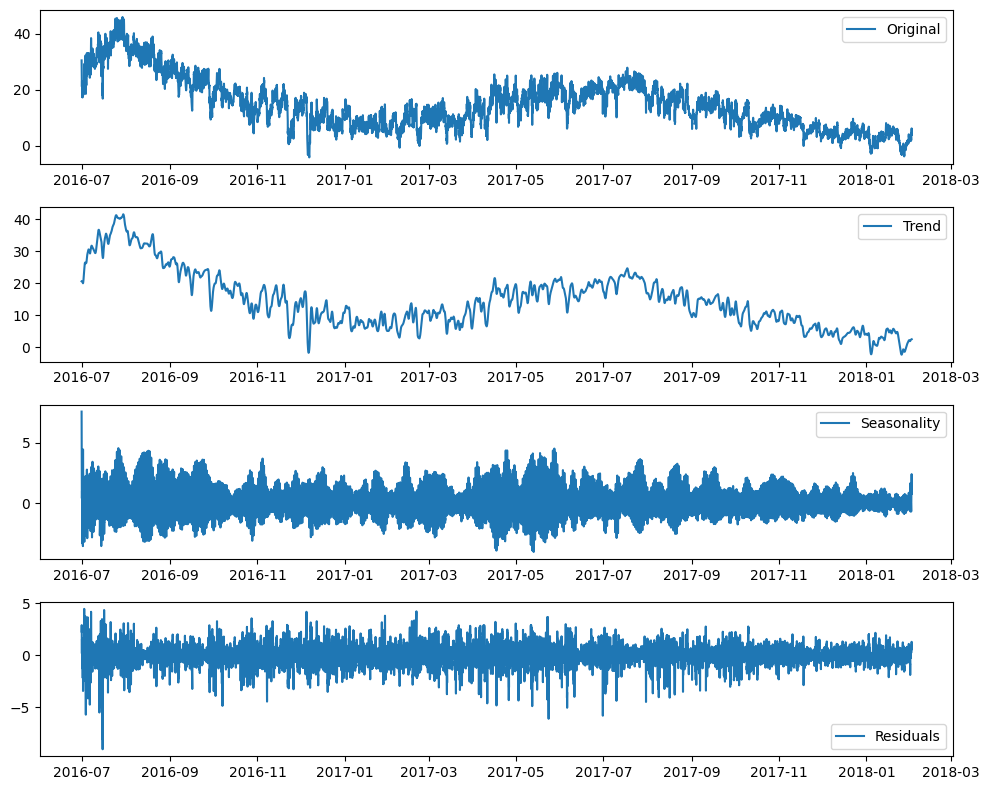

In [6]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# 读取数据集
file_path = "D:\OneDrive\Project\Reverse_Distill_Training\data\ETT-small\ETTh1.csv"  # 替换为你的文件路径
data = pd.read_csv(file_path, parse_dates=[0], index_col=0)  # 假设第一列是时间戳

# 选择一个变量进行分析（这里假设选择第一个变量，你可以根据需要修改）
variable_name = 'OT'
series = data[variable_name]

# 定义预测窗口大小&季节项
forecast_horizon = 24 # 预测步数
sp = 24
# 划分训练集和测试集
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

# ARIMA模型
# 自动选择ARIMA模型的参数
from pmdarima import auto_arima

# 使用auto_arima自动选择参数（这里没加季节项，自动选择比较慢，如果需要请用下边的注释替换掉对应的部分！)
# arima_model = auto_arima(series, seasonal=True, m=sp, trace=True, error_action='ignore', suppress_warnings=True)
arima_model = auto_arima(train, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
arima_params = arima_model.get_params()
print("Selected ARIMA parameters:", arima_params)

# 使用最佳参数重新训练模型
arima_model = ARIMA(train, order=arima_params['order'])
arima_fit = arima_model.fit()

# 预测
arima_forecast = arima_fit.forecast(steps=forecast_horizon)
arima_mae = mean_absolute_error(test[:forecast_horizon], arima_forecast)
arima_mse = mean_squared_error(test[:forecast_horizon], arima_forecast)
print(f"ARIMA MAE: {arima_mae}, ARIMA MSE: {arima_mse}")

# 指数平滑模型
holt_winters_model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=sp)
holt_winters_fit = holt_winters_model.fit()

# 预测
holt_winters_forecast = holt_winters_fit.forecast(steps=forecast_horizon)
holt_winters_mae = mean_absolute_error(test[:forecast_horizon], holt_winters_forecast)
holt_winters_mse = mean_squared_error(test[:forecast_horizon], holt_winters_forecast)
print(f"Holt-Winters MAE: {holt_winters_mae}, Holt-Winters MSE: {holt_winters_mse}")

# STL分解
# STL分解主要用于分析数据的季节性、趋势和残差
stl = STL(train)
stl_result = stl.fit()

# 可视化STL分解结果
plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(train, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(stl_result.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(stl_result.seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(stl_result.resid, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()
